In [2]:
import os
import sys
import subprocess
import natsort

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import astropy
from astropy.io import fits
from astropy.io import ascii
import astropy.wcs as pywcs
import numpy as np

In [4]:
import jwst
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst import assign_wcs
from jwst.assign_wcs import assign_wcs_step

In [6]:
import vos

2020-03-25 17:48:13,483 - stpipe - INFO - Using config file /home/jovyan/.config/vos/vos-config.
2020-03-25 17:48:13,485 - stpipe - INFO - Using config file /home/jovyan/.config/vos/vos-config.


In [7]:
print('Versions')
print('astropy:',astropy.__version__)
print('pipeline:',jwst.__version__)
print('numpy:',np.__version__)

Versions
astropy: 4.0
pipeline: 0.15.1
numpy: 1.18.1


In [9]:
#Set up directories for different levels of processing
os.chdir('/scratch')
cwd = os.getcwd()
rawdir=os.path.join(cwd,'raw')
det1dir=os.path.join(cwd,'det1')
im2dir=os.path.join(cwd,'calim2')
im3dir=os.path.join(cwd,'calim3')
#spec2dir=cwd+'/calspec2'
#spec3dir=cwd+'/calspec3'
if not os.path.exists(rawdir):
    os.mkdir(rawdir)
if not os.path.exists(det1dir):
    os.mkdir(det1dir)
if not os.path.exists(im2dir):
    os.mkdir(im2dir)
if not os.path.exists(im3dir):
    os.mkdir(im3dir)
#os.mkdir(spec2dir)
#os.mkdir(spec3dir)
configdir=cwd+'/config'

In [8]:
#Get JWST pipeline config files
os.system('collect_pipeline_cfgs %s' % configdir)

0

In [15]:
#os.remove(os.path.join(rawdir,'jw00042001001_01101_00001_nis_uncal.fits'))

In [27]:
#Use vos to retreive the raw files from CANFAR vospace
client = vos.Client()
demofile = 'demonirissimages.tar'
client.copy('vos:cjw/%s' % demofile, rawdir)
os.system('tar xvf %s --directory=%s' % (os.path.join(rawdir,demofile),rawdir))
os.remove(os.path.join(rawdir,demofile))

In [28]:
#Get raw images to process 
dirlist = natsort.natsorted(os.listdir(rawdir))
dirlist[:] = (value for value in dirlist if value.startswith('jw') and value.endswith('.fits'))
numimages = len(dirlist)
print (numimages,' raw images to process')

4  raw images to process


In [30]:
#Do level 1 and 2 processing for each raw file - go make a cup of tea, takes ~13 minutes for the 4 raw files
for j in range(numimages):
    raw_image = os.path.join(rawdir,dirlist[j])
    config = os.path.join(configdir,'calwebb_detector1.cfg')
    result = Detector1Pipeline.call(raw_image, config_file=config, output_dir=det1dir, save_results=True)
    rate_image = os.path.join(det1dir,dirlist[j].replace('_uncal.fits','_rate.fits'))
    config = os.path.join(configdir,'calwebb_image2.cfg')
    result = Image2Pipeline.call(rate_image, config_file=config, output_dir=im2dir, save_results=True)

2020-03-24 23:04:51,503 - stpipe - WARNING - /opt/conda/envs/jwstdp/lib/python3.7/site-packages/jwst/extern/configobj/validate.py:647: ResourceWarning: unclosed <ssl.SSLSocket fd=48, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.17.0.2', 38738), raddr=('132.246.217.37', 443)>
  fun_kwargs = dict([(str(key), value) for (key, value) in list(fun_kwargs.items())])

2020-03-24 23:04:51,504 - stpipe - WARNING - /opt/conda/envs/jwstdp/lib/python3.7/site-packages/jwst/extern/configobj/validate.py:647: ResourceWarning: unclosed <socket.socket fd=59, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.17.0.2', 53652), raddr=('132.246.217.37', 80)>
  fun_kwargs = dict([(str(key), value) for (key, value) in list(fun_kwargs.items())])

2020-03-24 23:04:51,505 - stpipe - WARNING - /opt/conda/envs/jwstdp/lib/python3.7/site-packages/jwst/extern/configobj/validate.py:647: ResourceWarning: unclosed <ssl.SSLSocket fd=60, family=AddressFamily.A

2020-03-25 18:16:37,863 - stpipe - WARNING - /opt/conda/envs/jwstdp/lib/python3.7/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='/scratch/calim3/demo_NIRISS_F200W_image_i2d.fits' mode='rb' closefd=True>
  """



jw01208023001_01101_00001_nis_cal.fits
Filename: /scratch/calim2/jw01208023001_01101_00001_nis_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     251   ()      
  1  SCI           1 ImageHDU        55   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [14051B]   


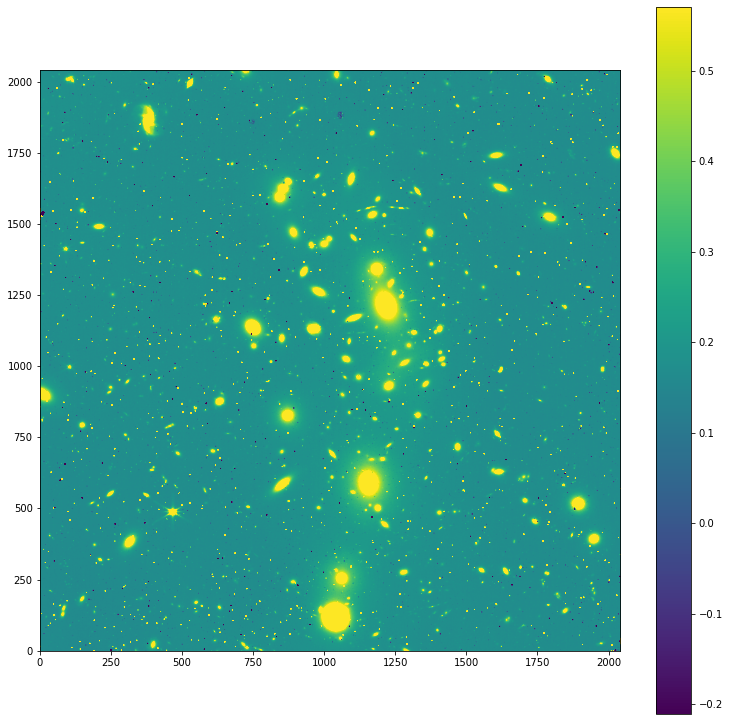

In [33]:
#Show a level 2 calibrated image
dirlist = natsort.natsorted(os.listdir(im2dir))
dirlist[:] = (value for value in dirlist if value.startswith('jw') and value.endswith('_cal.fits'))
print (dirlist[0])
dirim = fits.open(os.path.join(im2dir,dirlist[0]))
dirim.info()
#remove unilluminated reference pixels
datatrim=dirim['SCI'].data[4:2044,4:2044]
ys,xs = datatrim.shape
vmin = np.median(datatrim)-0.03*np.std(datatrim)
vmax = vmin+0.06*np.std(datatrim)
plt.figure(figsize=(13,13))
plt.imshow(datatrim,vmin=vmin, vmax=vmax)
plt.xlim(0,xs)
plt.ylim(0,ys)
plt.colorbar()
plt.show()


In [12]:
#Make association file based on level 2 images
prodname = 'demo_NIRISS_F200W_image'
#prodname='jw01208023001_01101_F115W_im'
filesforasn = im2dir+"/*cal.fits"
asnfile = 'direct_asn.json'
osasn = "asn_from_list -o %s --product-name %s --rule Asn_Image %s" % (asnfile,prodname,filesforasn)
osasncall = subprocess.check_call(osasn,shell=True)

In [13]:
#Run level 3 processing
config = os.path.join(configdir,'calwebb_image3.cfg')
result = Image3Pipeline.call(asnfile, config_file=config, output_dir=im3dir, save_results=True)

2020-03-25 17:53:19,617 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2020-03-25 17:53:19,619 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2020-03-25 17:53:19,621 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2020-03-25 17:53:19,623 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2020-03-25 17:53:19,625 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2020-03-25 17:53:19,626 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2020-03-25 17:53:19,716 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('direct_asn.json',).
2020-03-25 17:53:19,723 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/scratch/calim3', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True,

2020-03-25 18:16:26,471 - stpipe - WARNING - /opt/conda/envs/jwstdp/lib/python3.7/site-packages/ipykernel_launcher.py:6: ResourceWarning: unclosed file <_io.FileIO name='/scratch/calim3/demo_NIRISS_F200W_image_i2d.fits' mode='rb' closefd=True>
  



demo_NIRISS_F200W_image_i2d.fits
-0.175186 0.7169938


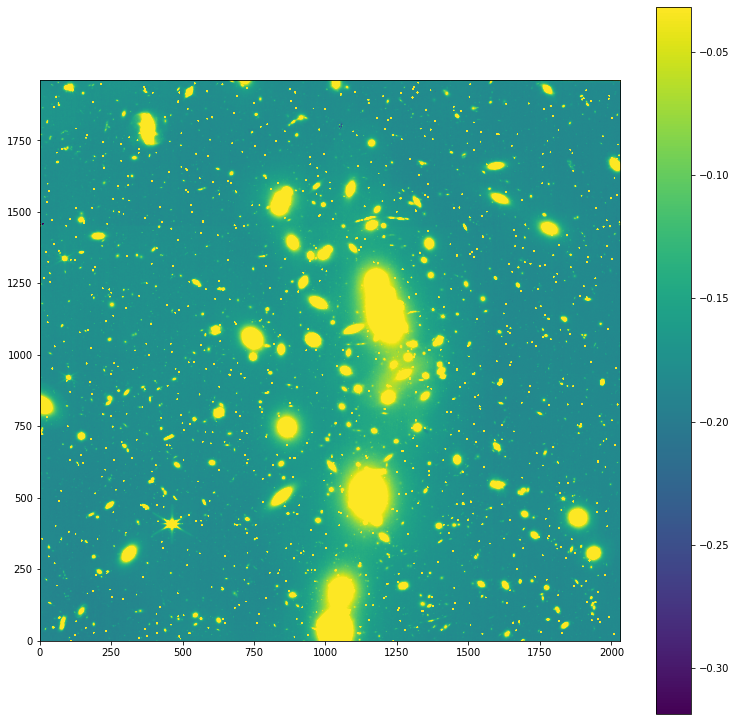

In [32]:
#Show the level 3 calibrated image
#Note how the negative bad pixels in the level 2 image are no longer visible
dirlist = natsort.natsorted(os.listdir(im3dir))
dirlist[:] = (value for value in dirlist if value.endswith('_i2d.fits'))
print (dirlist[0])
dirim = fits.open(os.path.join(im3dir,dirlist[0]))
#dirim.info()
#trim off low exposure edges
datatrim=dirim['SCI'].data[100:-10,10:-10]
ys,xs = datatrim.shape
vmin = np.median(datatrim)-0.2*np.std(datatrim)
vmax = vmin+0.4*np.std(datatrim)
print (np.median(datatrim),np.std(datatrim))
plt.figure(figsize=(13,13))
plt.imshow(datatrim,vmin=vmin, vmax=vmax)
plt.xlim(0,xs)
plt.ylim(0,ys)
plt.colorbar()
plt.show()

In [ ]:
#store level 2 and level 3 results to vospace before exiting container
#client.copy(im2dir, 'vos:cjw/')
#client.copy(im3dir, 'vos:cjw/')

In [ ]:
#clean up directories on vm if not going to use these data again but keeping vm alive
#shutil.rmtree(configdir)
#shutil.rmtree(rawdir)
#shutil.rmtree(det1dir)
#shutil.rmtree(im2dir)
#shutil.rmtree(im3dir)
#shutil.rmtree(spec2dir)
#shutil.rmtree(spec3dir)